In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import numpy as np
from astropy.io import fits
import warnings
from scipy import optimize
# import muse_tools as mt
import matplotlib.pyplot as plt
from astropy.stats import gaussian_sigma_to_fwhm
from telassar import PVSlice
import astropy.units as u



def gauss2D(amp, x0, y0, xsig, ysig):
    return lambda x, y: amp * np.exp(-(((x0 - x)/xsig)**2 +
                                       ((y0 - y)/ysig)**2)/2)

def moments(data):
    total = np.abs(data).sum()
    Y, X = np.indices(data.shape)
    y = np.argmax((X * np.abs(data)).sum(axis = 1) / total)
    x = np.argmax((Y * np.abs(data)).sum(axis = 0) /total)
    col = data[int(y), :]
    row = data[:, int(x)]
    xwidth = np.sqrt(np.abs((np.arange(col.size) - y)*col).sum() / 
                     np.abs(col).sum())
    ywidth = np.sqrt(np.abs((np.arange(row.size) - x)*row).sum() /
                     np.abs(row).sum())
    height = data.max()
    mom = np.array([ywidth, xwidth])
    return height, y, x, ywidth, xwidth

def fitgauss(data):
    params = (moments(data))
    errorfunction = lambda p: np.ravel(gauss2D(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, x0 = params)
    return p

In [37]:
f = fits.open('../SII_rotated.fits')[0]
    #'../multigauss/SII_rotated.fits')[0]
data = f.data
hdr = f.header

muse_pv = np.sum(data[:, :, 19:29], axis = 2).T
xshoo_pv = fits.open('data/HD163296_SIIF_6730.fits')[0]
xsh_data = xshoo_pv.data
xsh_hdr = xshoo_pv.header
xsh_hdr

SIMPLE  =                    T /Primary Header created by MWRFITS v1.2          
BITPIX  =                  -64 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                  149 /                                                
NAXIS2  =                  330 /                                                
EXTEND  =                    T /Extensions may be present                       
CRPIX1  =                    1 /                                                
CDELT1  =        6.68566370727 /                                                
CRVAL1  =       -395.354586567 /                                                
CRPIX2  =                  329 /                                                
CDELT2  =             0.200000 /                                                
CRVAL2  =             -25.3000 /                                                

<IPython.core.display.Javascript object>


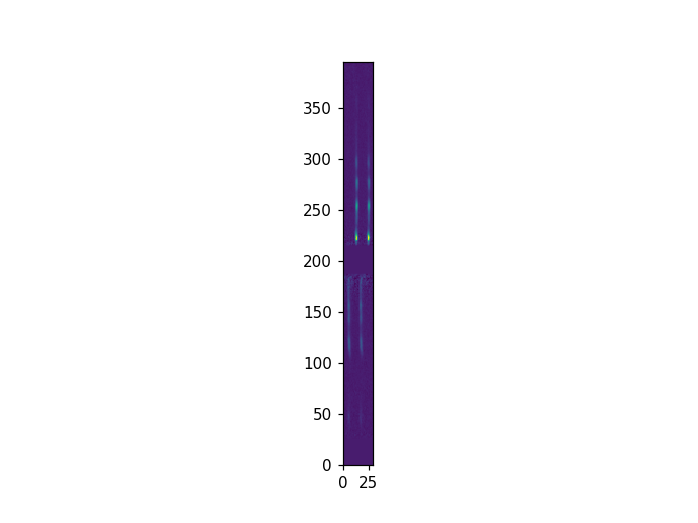

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.imshow(muse_pv, origin = 'lower')

In [38]:

muse_sii = PVSlice(data = muse_pv, header=hdr)
xshoo_sii = PVSlice('data/HD163296_SIIF_6730.fits')


In [39]:
xshoo_sii.world

WCS Keywords

Number of WCS axes: 2
CTYPE : 'OFFSET'  'VELO'  
CRVAL : -25.3  -395.354586567  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.2  6.68566370727  
NAXIS : 330  149

<IPython.core.display.Javascript object>


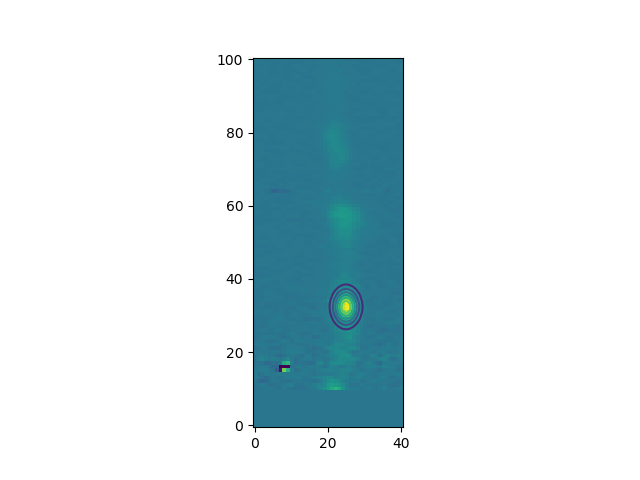

[3.52816464e-16 3.23795895e+01 2.49408304e+01 3.08250830e+00
 2.23585760e+00]


In [79]:
%matplotlib notebook

plt.imshow(data[140:241, 60:101], origin = 'lower')
plt.contour(fit(Y, X))
print(p)

In [40]:
pv2 = xshoo_sii.spectral_window(vmin = -400, vmax = 390, unit = u.Unit('km/s'))
#test = pv.spectral_window(vmin = 200, vmax = 300, unit = u.Unit('km/s'))

#pv2 = pv2.data * 1e16
#new_pv += np.abs(new_pv.min())
#new_pv.max()
pv2.world

WCS Keywords

Number of WCS axes: 2
CTYPE : 'OFFSET'  'VELO'  
CRVAL : -25.3  -395.354586567  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.2  6.68566370727  
NAXIS : 330  119

In [41]:
lines = {
        'OI6300':   [6300.304, 'Angstrom', r'$[\mathrm{OI}]\lambda 6300\AA$'],
        'OI6363':   [6363.777, 'Angstrom', r'$[\mathrm{OI}]\lambda 6363\AA$'],
        'NII6548':  [6548.04, 'Angstrom', r'$[\mathrm{NII}]\lambda 6548\AA$'],
        'NII6583':  [6583.46,  'Angstrom', r'$[\mathrm{NII}]\lambda 6583\AA$'],
        'HAlpha':   [6562.8,  'Angstrom', r'$\mathrm{H}\alpha$'],
        'HBeta':    [4861.325,  'Angstrom', r'$\mathrm{H}\beta$'],
        'SII6716':  [6716.44,  'Angstrom', r'$[\mathrm{SII}]\lambda 6716\AA$'],
        'SII6731':  [6730.81,  'Angstrom', r'$[\mathrm{SII}]\lambda 6730\AA$'],
        'CaII7291': [7291.47, 'Angstrom', r'$[\mathrm{CaII}]\lambda 7291\AA$'],
        'CaII7324': [7323.89, 'Angstrom', r'$[\mathrm{CaII}]\lambda 7324\AA$']
}



<IPython.core.display.Javascript object>


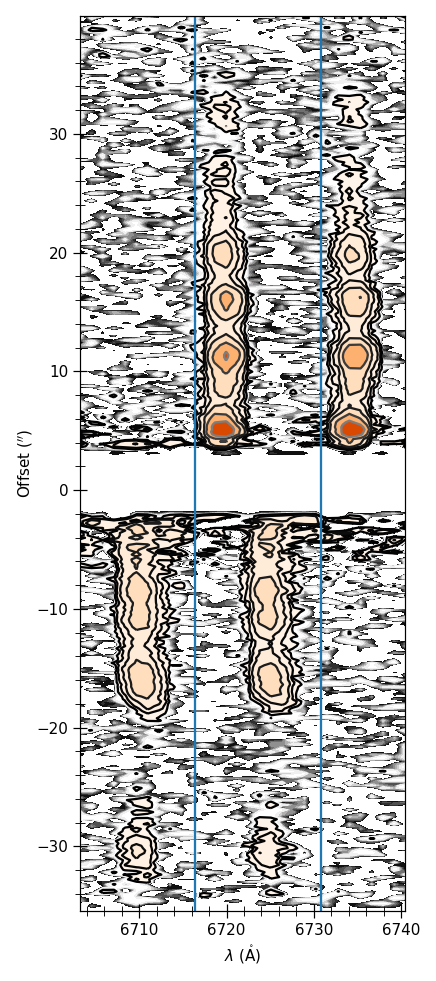

In [82]:
%matplotlib notebook

from telassar.plotter import ImPlotter

'''data = pv2.data.copy()

fig, ax = plt.subplots(figsize = (5,9))
cax = ax.imshow(data, origin = 'lower', interpolation = 'nearest')
ax.format_coord = ImPlotter(pv2, data)
'''
#pv2.plot()
mx = muse_sii.world.get_spatial_end()
muse_sii = muse_sii.spatial_window(amin = -35., amax = mx, unit = u.Unit('arcsec'))
muse_sii.plot_contours()
#ax = plt.gca()
#ax.set_aspect('auto')
plt.axvline(x= 6730.81)
plt.axvline(x = 6716.44)

In [63]:
muse_sii.info()
u.Unit(muse_sii.world.spatial_unit).to_string()

[INFO] 373 x 30 PVSlice (no name)
[INFO] .data(373 x 30) (arcsec Angstrom)
[INFO] spatial extent:(-34.926757731648", 39.473242268352") step:(0.200") 
[INFO] spectral extent:(6703.750, 6740.000) Angstrom step:(1.250 Angstrom) 


'arcsec'

In [92]:
from telassar.plotter import get_plot_extent
get_plot_extent(pv2.world)

(-395.854586567, 394.05373089086, -25.8, 41.0)

<IPython.core.display.Javascript object>


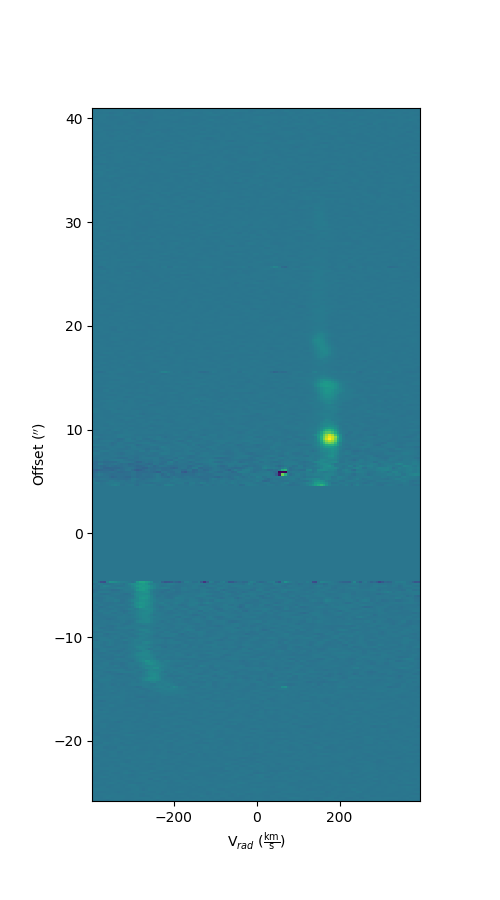

In [84]:
%matplotlib notebook

pv2.plot(scale = 'linear', imshow_kws = {'aspect' : 25})

In [34]:
pv2.world.pix2offset(40, unit = pv2.world.spatial_unit)

-17.3